# 📎IMDB Datasets with GRU

## PyTorch

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5, Loss: 0.5801
Epoch 2/5, Loss: 0.3858
Epoch 3/5, Loss: 0.2717
Epoch 4/5, Loss: 0.1939
Epoch 5/5, Loss: 0.1356

Evaluation Metrics:
Accuracy:  0.8711
Precision: 0.8741
Recall:    0.8670
F1 Score:  0.8706
AUC:       0.9403


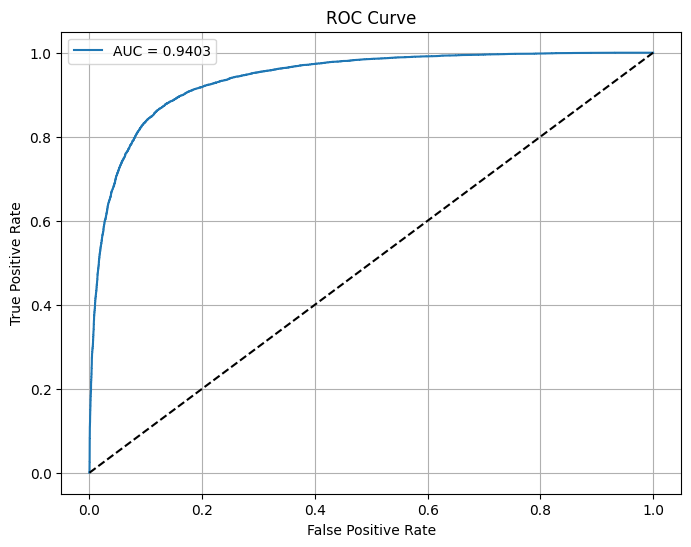

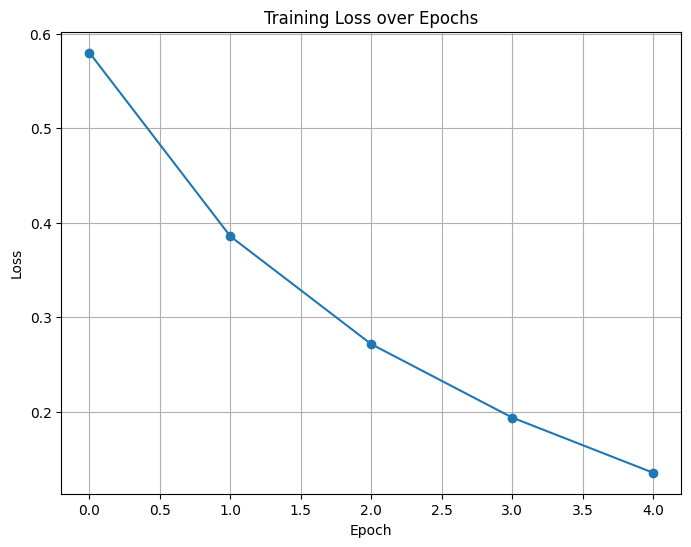

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Config
num_words = 30000
maxlen = 300
batch_size = 64
embedding_dim = 128
hidden_size = 64
num_layers = 1
output_size = 1
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

x_train = torch.LongTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_test = torch.LongTensor(x_test)
y_test = torch.FloatTensor(y_test)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# GRU Model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(num_words, input_size)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return self.sigmoid(out)

model = GRUModel(embedding_dim, hidden_size, num_layers, output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, loader):
    model.train()
    train_loss, correct = 0, 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).unsqueeze(1)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            probs = model(x_batch).squeeze()
            preds = (probs >= 0.5).float()
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

# Training loop
train_losses = []
for epoch in range(num_epochs):
    loss = train(model, train_loader)
    train_losses.append(loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Evaluation
y_true, y_pred, y_prob = evaluate(model, test_loader)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

print(f"\nEvaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(8,6))
plt.plot(train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


## TensorFlow

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,877,313 (14.79 MB)

 Trainable params: 3,877,313 (14.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 152s 476ms/step - accuracy: 0.6867 - loss: 0.5534 - val_accuracy: 0.8726 - val_loss: 0.3068
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.9163 - loss: 0.2223 - val_accuracy: 0.8688 - val_loss: 0.3085
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 485ms/step - accuracy: 0.9535 - loss: 0.1340 - val_accuracy: 0.8752 - val_loss: 0.3452
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 199s 475ms/step - accuracy: 0.9784 - loss: 0.0649 - val_accuracy: 0.8720 - val_loss: 0.4093
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 207s 492ms/step - accuracy: 0.9874 - loss: 0.0397 - val_accuracy: 0.8590 - val_loss: 0.4904
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step

Evaluation Metrics:
Accuracy:  0.8514
Precision: 0.8186
Recall:    0.9029
F1 Score:  0.8587
AUC:       0.9265


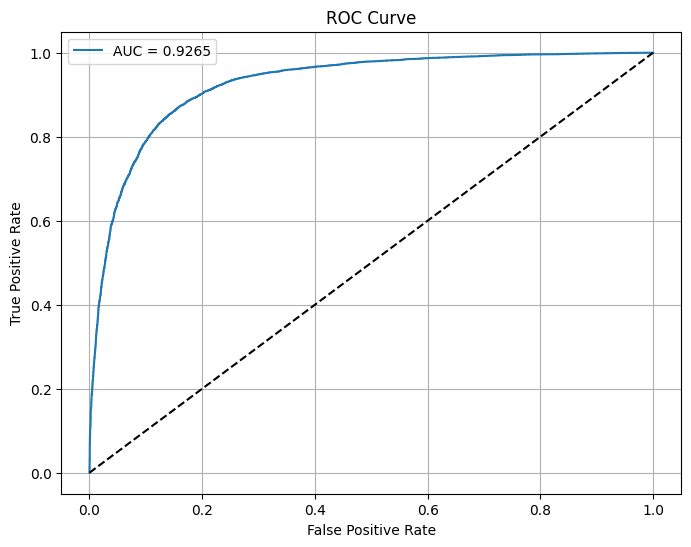

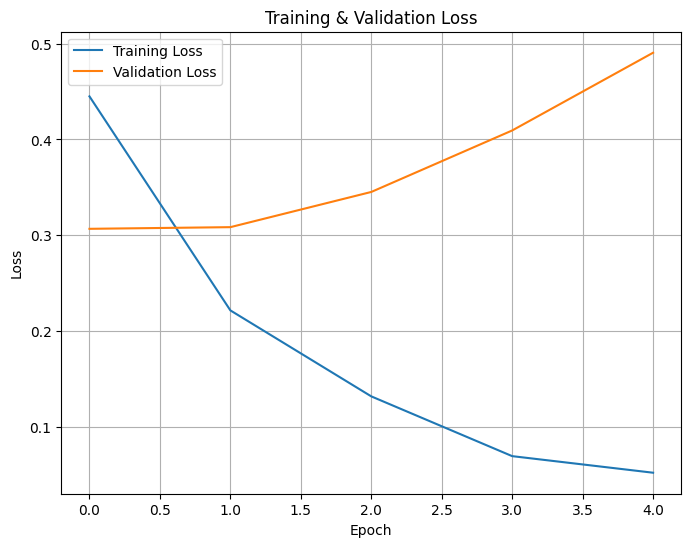

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Config
num_words = 30000
maxlen = 300
batch_size = 64
embedding_dim = 128
hidden_size = 64
num_epochs = 5

# Load & preprocess IMDB data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Build GRU model using Functional API
input_ = Input(shape=(maxlen,))
x = Embedding(num_words, embedding_dim)(input_)
x = GRU(hidden_size, return_sequences=False)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(input_, output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=1
)

# Predict
y_prob = model.predict(x_test).flatten()
y_pred = (y_prob >= 0.5).astype("int32")

# Evaluation metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\nEvaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Training loss & accuracy plot
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()
